In [9]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from scipy import ndimage
import torch
import time
import random
from torchvision.transforms import RandomResizedCrop
from data.swarmset import ContinuingDataset, SwarmDataset
from src.networks.embedding import NoveltyEmbedding
from src.networks.archive import DataAggregationArchive
from src.networks.ensemble import Ensemble
import numpy as np
import cv2

BATCH_SIZE = 516
PRETRAINING = True
target = 0.0001
loss = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lr = 0.03 * BATCH_SIZE / 256
ensemble = Ensemble(size=3, output_size=32, lr_series=[lr, lr, lr], learning_decay=0.7, decay_step=1, threshold=100.0, weight_decay=10e-6, new_model=True, margin=100)
# ensemble.load_ensemble("../checkpoints/ensembles/toy-SIMCLR", full=True)
sampled_dataset = SwarmDataset("../data/tinytoy", rank=0)

def resizeInput(X, w=200):
    frame = X.astype(np.uint8)
    resized = cv2.resize(frame, dsize=(w, w), interpolation=cv2.INTER_AREA)
    return resized

def translate(img, offset=(10, 10)):
    h, w = img.shape
    xoff, yoff = offset
    if xoff < 0: xpadding = (0, -xoff)
    else: xpadding = (xoff, 0)
    if yoff < 0: ypadding = (0, -yoff)
    else: ypadding = (yoff, 0)
    img = np.pad(img, (xpadding, ypadding))

    if xoff >= 0 and yoff >= 0:
        return img[:w, :w]
    elif xoff < 0 and yoff >= 0:
        return img[-w:, :w]
    elif xoff >= 0 and yoff < 0:
        return img[:w, -w:]
    return img[-w:, -w:]

def zoom_at(img, zoom, coord=None):
    # Adapted from https://stackoverflow.com/questions/69050464/zoom-into-image-with-opencv
    h, w = [ zoom * i for i in img.shape ]
    if coord is None: cx, cy = w/2, h/2
    else: cx, cy = [ zoom*c for c in coord ]
    img = cv2.resize( img, (0, 0), fx=zoom, fy=zoom)
    img = img[ int(round(cy - h/zoom * .5)) : int(round(cy + h/zoom * .5)),
               int(round(cx - w/zoom * .5)) : int(round(cx + w/zoom * .5))]
    return img

def get_color_distortion(X, s=3.0):
    X = X + s * np.random.randn(X.shape[0], X.shape[1])
    return X

def getRandomTransformation(image, k=2):
    transformation_choices = ["Rotation", "Blur", "Zoom", "Translate", "Distort", "ResizedCrop"]
    # weights = [0.4, 0.3, 0.0, 0.2]
    # weights = [1.0, 0.0, 0.0, 0.0]
    # choices = random.choices(transformation_choices, weights, k=k)
    choices = ["Distort", "ResizedCrop"]
    if "Rotation" in choices:
        theta = random.choice([90, 180, 270])
        image = ndimage.rotate(image, theta)
    elif "Blur" in choices:
        blur = random.choice([0.5, 1.0, 1.5])
        image = ndimage.gaussian_filter(image, sigma=blur)
    elif "Zoom" in choices:
        # zoom = random.choice([1.06, 1.12, 1.18])
        padding = random.choice([10])
        padded = np.pad(image, padding, mode='constant')
        image = resizeInput(padded, 50)
    elif "Translate" in choices:
        offsets = [i for i in range(-10, 10, 2)]
        offset = (random.choice(offsets), random.choice(offsets))
        # offset = (2, 2)
        image = translate(image, offset)
    elif "Distort" in choices:
        strength = random.choice([0.0, 0.5, 1.0, 3.0, 5.0])
        image = get_color_distortion(image, s=strength)
    elif "ResizedCrop" in choices:
        cropper = RandomResizedCrop(size=(50,50))
        image = cropper(image)
    return image

def pretraining(data, ensemble, data_cutoff=None, data_size=500):
    if data_cutoff is None:
        data_cutoff = len(data) - 1
    # np.random.seed(0)
    samples = np.random.random_integers(0, data_cutoff, (data_size, 2))
    total_loss = np.array([0.0 for i in range(len(ensemble.ensemble))])
    total_updates = 0
    pull_set = [k for k in range(len(samples))]
    random.shuffle(pull_set)
    for index in range(0, len(pull_set), BATCH_SIZE):
        i = pull_set[index]
        if total_updates % 20 == 0:
            print(f"Unsupervised Training.. {(total_updates * BATCH_SIZE * 100) / data_size}")

        AUGMENT_SIZE = 1
        if i + (BATCH_SIZE * AUGMENT_SIZE) >= len(pull_set):
            continue

        temp_losses = np.array([0.0 for _ in ensemble.ensemble])

        anchors = np.array([data[samples[i + (j % AUGMENT_SIZE)][0]][0] for j in range(AUGMENT_SIZE * BATCH_SIZE)])
        positives = np.array([getRandomTransformation(data[samples[i + (j % AUGMENT_SIZE)][0]][0], k=2) for j in range(AUGMENT_SIZE * BATCH_SIZE)])
        negatives = np.array([data[samples[i + (j % AUGMENT_SIZE)][1]][0] for j in range(AUGMENT_SIZE * BATCH_SIZE)])

        anchors = np.expand_dims(anchors, axis=1)
        positives = np.expand_dims(positives, axis=1)
        negatives = np.expand_dims(negatives, axis=1)

        losses = ensemble.train_batch(anchors, positives, negatives)
        temp_losses += losses

        total_loss += temp_losses
        total_updates += 1

    return total_loss, total_updates

t_1 = time.time()
EPOCHS = 100
if PRETRAINING:
    epochs = 0
    loss_history = []
    # while loss > target:
    while epochs < EPOCHS:
        losses, total_updates = pretraining(sampled_dataset, ensemble, data_cutoff=None, data_size=25000)
        average_loss = losses / total_updates
        lr = ensemble.evaluate_lr(average_loss)
        locale_loss = sum(average_loss) / len(average_loss)
        loss_history.append(locale_loss)
        loss = (sum(loss_history[-3:]) / 3) if len(loss_history) > 3 else 50
        print(f"LR: {lr}")
        print(f"Losses: {average_loss}")
        print(f"Epoch {epochs}, loss: {locale_loss}, windowed_loss: {loss}")
        epochs += 1

print(f"Total Pre-training Time: {time.time() - t_1}")
ensemble.save_ensemble(f"../checkpoints/ensembles/{int(time.time())}", full=True)

/tmp/ipykernel_2852243/2830919202.py:99: DeprecationWarning: This function is deprecated. Please call randint(0, 500 + 1) instead
  samples = np.random.random_integers(0, data_cutoff, (data_size, 2))


Unsupervised Training.. 0.0
Unsupervised Training.. 41.28
Unsupervised Training.. 82.56
LR: [[0.060468749999999995], [0.060468749999999995], [0.060468749999999995]]
Losses: [ 4453.71340481 11499.54998571    25.50813214]
Epoch 0, loss: 5326.25717422035, windowed_loss: 50
Unsupervised Training.. 0.0
Unsupervised Training.. 41.28
Unsupervised Training.. 82.56
LR: [[0.060468749999999995], [0.060468749999999995], [0.060468749999999995]]
Losses: [ 236.21773293   96.46597599 1312.44556706]
Epoch 1, loss: 548.3764253296212, windowed_loss: 50
Unsupervised Training.. 0.0
Unsupervised Training.. 0.0
Unsupervised Training.. 41.28
Unsupervised Training.. 82.56
LR: [[0.060468749999999995], [0.060468749999999995], [0.060468749999999995]]
Losses: [  0.77213971   0.         519.56458333]
Epoch 2, loss: 173.4455743489442, windowed_loss: 50
Unsupervised Training.. 0.0
Unsupervised Training.. 41.28
Unsupervised Training.. 82.56
LR: [[0.042328124999999994], [0.042328124999999994], [0.060468749999999995]]
L

KeyboardInterrupt: 

torch.Size([1, 50, 50])


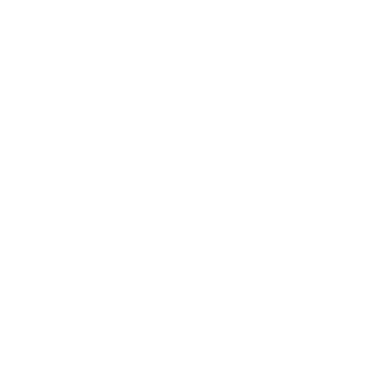

In [134]:
from torchvision import transforms
from torchvision.transforms import RandomResizedCrop
def get_color_distortion(X, s=3.0):
    X = X + s * torch.randn(X.shape)
    return X

sampled_dataset = SwarmDataset("../data/tinytoy", rank=0)
img = torch.tensor(sampled_dataset[0][0]).unsqueeze(0)
print(img.shape)

cropper = RandomResizedCrop(size=(50,50))
img = cropper(img)

import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(img.squeeze(0), cmap="Greys")
plt.show()